Intro

In [1]:
import pandas as pd
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

In [2]:
fasta_amostras_file = "../data_prep/omic_data/H3N2_HA_Merged_Complete.fasta"
fasta_vacinas_file="../data_prep/omic_data/vaccine_sequences.fasta"
output_fasta = "../data_prep/omic_data/alignment_proteins.fasta"

# Dicionário para renomear as vacinas
mapping_vacinas = {
    "OQ350818.1": "HK2014",
    "MG974450.1": "KAN2017",
    "OR533546.1": "TAS2020",
    "PX230021.1": "DAR2021",
    "OP213690.1": "MAS2022"
}

def find_cds_and_translate(sequence):
    # Procura o primeiro ATG e traduz a partir daí
    start_idx = sequence.find("ATG")
    if start_idx != -1:
        # Traduz até o primeiro Stop codon
        return sequence[start_idx:].translate(to_stop=True)
    return sequence.translate(to_stop=True)

# 1. Carregar as 5 vacinas (ADN)
vacinas_dna = list(SeqIO.parse(fasta_vacinas_file, "fasta"))
# 2. Carregar as 240 amostras (ADN)
amostras_dna = list(SeqIO.parse(fasta_amostras_file, "fasta"))

lista_proteinas = []

for vac in vacinas_dna:
    prot_seq = find_cds_and_translate(vac.seq)
    
    # Tenta encontrar o nome amigável, se não encontrar mantém o original
    novo_id = mapping_vacinas.get(vac.id, vac.id)
    
    lista_proteinas.append(SeqRecord(prot_seq, id=novo_id, description="VACINA"))

# Traduzir amostras
for amostra in amostras_dna:
    prot_seq = find_cds_and_translate(amostra.seq)
    lista_proteinas.append(SeqRecord(prot_seq, id=amostra.id, description="AMOSTRA"))

# 3. Guardar tudo num único ficheiro para o alinhamento
#SeqIO.write(lista_proteinas, output_fasta, "fasta")
#print("Ficheiro pronto para alinhamento!")

c:\Users\Alexandre\AppData\Local\Programs\Python\Python312\Lib\site-packages\Bio\Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Foram alinhadas no MAFFT, resultado: aligned_proteins.fasta

Base do dataset:


1- Hamming distance

In [3]:
def hamming_distance(s1, s2):
    # Ignora gaps (-) no cálculo da distância para não penalizar seqs parciais nas pontas
    return sum(1 for a, b in zip(s1, s2) if a != b and a != "-" and b != "-")

In [4]:
aligned_fasta=list(SeqIO.parse("../data_prep/omic_data/aligned_proteins.fasta", "fasta"))


vacinas=[protein for protein in aligned_fasta if protein.description.split()[1] == 'VACINA']
amostras=[protein for protein in aligned_fasta if protein.description.split()[1] == 'AMOSTRA']

dict_vacinas={}
for vacina in vacinas:
    dict_vacinas [vacina.id]= vacina.seq

rows = []
for amostra in amostras:
    accession = amostra.id.split('.')[0]
    seq_str = str(amostra.seq)

    row = {
        'id': accession,
        # Features Genéticas (Distâncias)
        'dist_HK2014': hamming_distance(seq_str,dict_vacinas['HK2014']),
        'dist_KAN2017': hamming_distance(seq_str,dict_vacinas['KAN2017']),
        'dist_TAS2020': hamming_distance(seq_str,dict_vacinas['TAS2020']),
        'dist_DAR2021': hamming_distance(seq_str,dict_vacinas['DAR2021']),
        'dist_MAS2022': hamming_distance(seq_str,dict_vacinas['MAS2022']),
    }
    rows.append(row)

# 6. Gerar o DataFrame Final
dataset_ml = pd.DataFrame(rows)


print(f"Sucesso! Processadas {len(amostras)} amostras.")
print(f"Colunas criadas: {dataset_ml.columns.tolist()}")
    

Sucesso! Processadas 240 amostras.
Colunas criadas: ['id', 'dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021', 'dist_MAS2022']


In [5]:
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022
0,MK898525,9,16,20,26,33
1,MK502696,7,15,18,24,31
2,MK400756,7,15,18,24,31
3,MK400758,7,15,18,24,31
4,MK381485,7,15,18,24,31
...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43
236,LC155888,21,20,31,36,41
237,LC155876,22,21,29,34,39
238,LC155892,23,24,30,35,39


2-Collection date

Não adicionamos já ao df_ML para poder testar posteriormente se melhora o modelo ou não

In [6]:
def date_to_decimal(date_str):
    try:
        dt = pd.to_datetime(date_str)
        year_part = dt.year
        # Calcula a fração do ano decorrida
        day_of_year = dt.timetuple().tm_yday
        is_leap = (year_part % 4 == 0 and (year_part % 100 != 0 or year_part % 400 == 0))
        days_in_year = 366 if is_leap else 365
        return year_part + (day_of_year / days_in_year)
    except:
        return None

Adicionamos ao df de metadados

In [7]:
metadados = pd.read_csv('../data_prep/omic_data/Metadados_H3N2_HA_Complete.csv')

Decimal_Date=[]
for _,row in metadados.iterrows():
    date= row['Collection_Date']
    Decimal_Date.append(date_to_decimal(date))

metadados['Decimal_Date']=Decimal_Date

3-pEpitope

pEpitope é um proxy de escape antigénico / falha vacinal -> o nosso Y

DOI:10.1016/j.vaccine.2019.03.068
https://doi.org/10.1016/j.vaccine.2004.08.028

In [8]:
epitopos = {
    "A": [122, 124, 126, 130, 131, 132, 133, 135, 137, 138, 140,
          142, 143, 144, 145, 146, 150, 152, 168],

    "B": [128, 129, 155, 156, 157, 158, 159, 160, 163, 165,
          186, 187, 188, 189, 190, 192, 193, 194, 196, 197, 198],

    "C": [44, 45, 46, 47, 48, 50, 51, 53, 54,
          273, 275, 276, 278, 279, 280,
          294, 297, 299, 300, 304, 305,
          307, 308, 309, 310, 311, 312],

    "D": [96, 102, 103, 117, 121, 167,
          170, 171, 172, 173, 174, 175, 176, 177,
          179, 182, 201, 203,
          207, 208, 209,
          212, 213, 214, 215, 216, 217, 218, 219,
          226, 227, 228, 229, 230,
          238, 240, 242, 244,
          246, 247, 248],

    "E": [57, 59, 62, 63, 67, 75, 78,
          80, 81, 82, 83,
          86, 87, 88,
          91, 92, 94, 109,
          260, 261, 262, 265]
}

def get_vaccine(decimal_date):
      year=int(decimal_date)
      if year <= 2016:
            ref_id = 'HK2014'
      elif 2017 <= year <= 2019:
            ref_id = 'KAN2017'
      elif year == 2020:
            ref_id = 'TAS2020'
      elif year == 2021:
            ref_id = 'DAR2021'
      else: # 2022, 2023, 2024, 2025
            ref_id = 'MAS2022'
            
      return ref_id

def calculate_pepitope(seq, vaccine_seq):

      p_epitope_dict={}

      for name,positions in epitopos.items():

            mismatch=0
      
            for pos in positions:
                 
                  if seq[pos-1]!= vaccine_seq[pos-1]: #as posições dos epitopos são contadas a apartir do 1, não do 0 como em python
                        mismatch+=1
            
            p_epitope_dict[name]=mismatch/len(positions)

      dominant_epitope_name = max(p_epitope_dict, key=p_epitope_dict.get)
      dominant_epitope_value = p_epitope_dict[dominant_epitope_name]
      return dominant_epitope_value
                  


In [9]:
p_epitopes=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    Decimal_Date= metadados[metadados['Accession'] == accession]['Decimal_Date']
    vaccine_id= get_vaccine(Decimal_Date)
    vaccine_seq=dict_vacinas[vaccine_id]

    p_epitopes.append(round(calculate_pepitope(seq,vaccine_seq),5))


dataset_ml['target_p_epitope']=p_epitopes

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_60788\2213697776.py:30: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year=int(decimal_date)


In [10]:
dataset_ml.iloc[:10]

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,target_p_epitope
0,MK898525,9,16,20,26,33,0.09756
1,MK502696,7,15,18,24,31,0.09756
2,MK400756,7,15,18,24,31,0.09756
3,MK400758,7,15,18,24,31,0.09756
4,MK381485,7,15,18,24,31,0.09756
5,MH885205,7,15,18,24,31,0.09756
6,MH779033,7,15,18,24,31,0.09756
7,MH779034,7,15,18,24,31,0.09756
8,MK381488,8,16,19,25,32,0.09756
9,MK400757,8,16,18,24,31,0.09756


$0.02$ a $0.10$ (Deriva Ligeira): Indica uma proteção vacinal ainda eficaz. O vírus começou a mudar, mas o sistema imunitário treinado pela vacina ainda reconhece bem a proteína.

$0.10$ a $0.18$ (Deriva Moderada): A eficácia da vacina começa a cair significativamente.

$0.19048$ (O "Limite de Falha"): Este valor é emblemático. Na literatura de Deem, o valor de $0.19$ é frequentemente citado como o limiar crítico de escape.

Anos em que a vacina "falhou" (como 2003/04 e 2014/15) apresentavam valores de $p_{Epitope}$ em torno de 0.19.Segundo a equação de eficácia ($VE = -2.47 \times p_{Epitope} + 0.47$), quando o $p_{Epitope}$ atinge ~0.19, a eficácia teórica da vacina aproxima-se de zero.

"For example, when pepitope is larger than 0.19, the vaccine no longer offers protection." DOI:10.1093/protein/gzp027

4-Distancia à sequencia consenso do dataset

In [11]:
consensus_seq=[]
for i in range(len(amostras[0].seq)):
    aa_col=[]
    for amostra in amostras:
        aa=amostra.seq[i]
        aa_col.append(aa)

    consensus_aa = max(aa_col, key=aa_col.count)
    consensus_seq.append(consensus_aa)
consensus_seq=''.join(consensus_seq)

Consensus_dist=[]

for amostra in amostras:
    seq=amostra.seq
    dist=hamming_distance(seq,consensus_seq)
    Consensus_dist.append(dist)

dataset_ml.insert(6,'dist_consensus',Consensus_dist)

In [12]:
dataset_ml.iloc[:10]

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,target_p_epitope
0,MK898525,9,16,20,26,33,7,0.09756
1,MK502696,7,15,18,24,31,5,0.09756
2,MK400756,7,15,18,24,31,5,0.09756
3,MK400758,7,15,18,24,31,5,0.09756
4,MK381485,7,15,18,24,31,5,0.09756
5,MH885205,7,15,18,24,31,5,0.09756
6,MH779033,7,15,18,24,31,5,0.09756
7,MH779034,7,15,18,24,31,5,0.09756
8,MK381488,8,16,19,25,32,6,0.09756
9,MK400757,8,16,18,24,31,6,0.09756


Machine Learning

Ridge Regression

Treino do modelo:
temporally stratified split

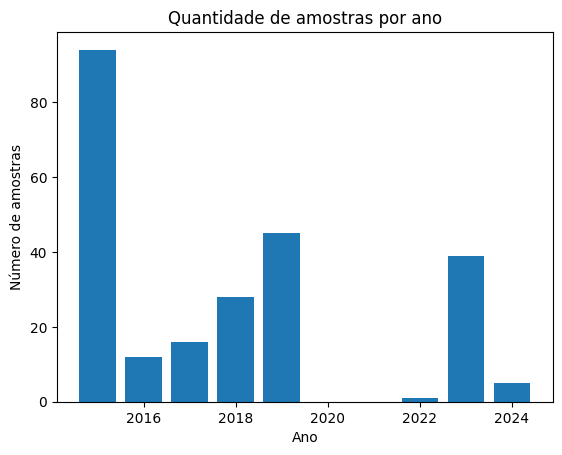

In [13]:
import matplotlib.pyplot as plt

metadados["Year"] = pd.to_datetime(metadados["Collection_Date"]).dt.year

contagem_por_ano = (
    metadados["Year"]
    .value_counts()
    .sort_index()
)
plt.figure()
plt.bar(contagem_por_ano.index, contagem_por_ano.values)
plt.xlabel("Ano")
plt.ylabel("Número de amostras")
plt.title("Quantidade de amostras por ano")
plt.show()


Due to sparse sampling during 2020–2021, a strict chronological split was not feasible. Therefore, a biologically motivated temporal cutoff was adopted, preserving recent post-pandemic strains for evaluation.

In [14]:
dataset_ml.insert(7,'Year',metadados['Year'])

In [15]:
train_df = dataset_ml[dataset_ml["Year"] <= 2018]
test_df  = dataset_ml[dataset_ml["Year"] >= 2019]

X_train = train_df.drop(columns=["id", "target_p_epitope", "Year"])
y_train = train_df["target_p_epitope"]

X_test  = test_df.drop(columns=["id", "target_p_epitope", "Year"])
y_test  = test_df["target_p_epitope"]


In [16]:
print("Train years:")
print(train_df["Year"].value_counts().sort_index())

print("\nTest years:")
print(test_df["Year"].value_counts().sort_index())


Train years:
Year
2015    94
2016    12
2017    16
2018    28
Name: count, dtype: int64

Test years:
Year
2019    45
2022     1
2023    39
2024     5
Name: count, dtype: int64


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

y_pred = ridge_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Erro Médio Quadrático (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Erro Médio Quadrático (MSE): 0.0020
R² Score: -0.5346
Root Mean Squared Error (RMSE): 0.0452


Em média, o modelo erra cerca de 4–5% da escala total do pEpitope

O R^2 negativo era de esperar visto que:
Linear models trained on pre-pandemic strains struggle to extrapolate antigenic evolution following major selective shifts.This motivated the use of non-linear models.

Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RF RMSE: {rmse_rf:.4f}")
print(f"RF R²: {r2_rf:.4f}")

RF RMSE: 0.0307
RF R²: 0.2940


Em média, o modelo erra cerca de ~3% da escala total do pEpitope. Muito bom para dados biológicos reais

Quanto ao R^2: ~30% da variância explicada em extrapolação temporal

In [19]:
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

importances

,Feature,Importance
0,dist_HK2014,0.343932
4,dist_MAS2022,0.285945
1,dist_KAN2017,0.177780
3,dist_DAR2021,0.088971
5,dist_consensus,0.063201
2,dist_TAS2020,0.040169


Melhorar modelo, mais features, mudar parametros, mudar o split.

# Machine Learning take 2

## Novas features:

## Mutações flag (literatura)

A Recommended Numbering Scheme for Influenza A HA Subtypes PMCID: PMC4229193  PMID: 25391151

Evolution of Influenza A(H3N2) Viruses in 2 Consecutive Seasons of Genomic Surveillance, 2021–2023 PMCID: PMC10715682  PMID: 38088981

In [20]:
mutacoes= {
    83: 'K',       # Glu -> Lys Aumento de Binding alpha2-6
    126: 'N',      # Ser -> Asn Aumento de Binding alpha2-6
    128: 'P',      # Ser -> Pro Aumento de Binding alpha2-6
    137: 'A',      # Ser -> Ala Aumento de Binding alpha2-6
    143: 'R',      # Gly -> Arg Aumento de Binding alpha2-6
    155: 'T',      # Ile -> Thr Aumento de Binding alpha2-6
    186: 'K',      # Asn -> Lys Aumento de Binding alpha2-6
    187: 'G',      # Asp -> Gly Aumento de Binding alpha2-6
    190: 'G',      # Glu -> Gly Aumento de Binding alpha2-6
    192: 'I',      # Thr -> Ile Aumento de Binding alpha2-6
    193: 'R',      # Lys -> Arg Aumento de Binding alpha2-6
    196: ('R', 'H'), # Gln -> Arg ou His Aumento de Binding alpha2-6
    197: 'K',      # Asn -> Lys Aumento de Binding alpha2-6
    214: 'I',      # Val -> Ile Aumento de Binding alpha2-6
    226: 'L',      # Gln -> Leu Aumento de Binding alpha2-6
    227: 'N',      # Ser -> Asn Aumento de Binding alpha2-6
    228: 'S',      # Gly -> Ser Aumento de Binding alpha2-6
    239: 'S',      # Pro -> Ser Aumento de Binding alpha2-6
    255: 'K',      # Glu -> Lys Aumento de Binding alpha2-6
    496: 'K' ,      # Arg -> Lys Aumento de Binding alpha2-6

    21: 'Any',  # Asn -> Qualquer (Loss of N-glycosylation; increased virulence) Mutações de perda de glicosilação 
    158: 'D',   # Asn -> Asp (Loss of N-glycosylation; increased binding and transmission) Mutações de perda de glicosilação 
    160: 'A',    # Thr -> Ala (Loss of N-glycosylation; increased binding and transmission) Mutações de perda de glicosilação 

    138: 'V',  # Ala -> Val mutacoes de infetividade SIAT
    156: 'S',
    159: 'Y'
}


In [21]:
mutation_columns = []

for pos, target_aa in mutacoes.items():
    col = []

    for amostra in amostras:
        aa = amostra.seq[pos - 1]  # posição biológica → Python

        hit = 0

        if target_aa == "Any":
            if aa != "N":
                hit = 1

        elif isinstance(target_aa, tuple):
            if aa in target_aa:
                hit = 1

        else:
            if aa == target_aa:
                hit = 1

        col.append(hit)

    mutation_columns.append((pos, col))



In [22]:
df_mutations = pd.DataFrame({
    pos: col for pos, col in mutation_columns
})

summary = pd.DataFrame({
    "posicao": df_mutations.columns,
    "n_amostras_com_mutacao": df_mutations.sum().values,
    "n_amostras_sem_mutacao": (len(df_mutations) - df_mutations.sum()).values
})

summary["variavel"] = summary["n_amostras_com_mutacao"].between(1, len(df_mutations)-1)

summary = summary.sort_values("n_amostras_com_mutacao", ascending=False)

summary


,posicao,n_amostras_com_mutacao,n_amostras_sem_mutacao,variavel
20,21,240,0,False
0,83,0,240,False
2,128,0,240,False
3,137,0,240,False
4,143,0,240,False
5,155,0,240,False
6,186,0,240,False
7,187,0,240,False
8,190,0,240,False
1,126,0,240,False


Infelizmente nenhuma das mutações encontradas na literatura variam no nosso dataset, logo o modelo não aprenderá nada com elas como features.

## N-Glycolisation Motifs:

Estudos de H3N2 ligam claramente antigénicidade ao padrão global de N‑glicosilação:
A sequence-based machine learning model for predicting antigenic distance for H3N2 influenza virus https://doi.org/10.3389/fmicb.2024.1345794

In [23]:
import re

def get_glycosylation_sites(sequence):
    # Regex para o motivo NXT/S onde X != P
    # Usamos lookahead (?=...) para encontrar motivos sobrepostos se existirem
    sequence = str(sequence)
    sites = set()
    for m in re.finditer(r'(?=N[^P][ST])', sequence):
        sites.add(m.start() + 1) # Posição biológica (base 1)
    return sites

def compare_glycosylation(sample_seq, vaccine_seq):
    sample_sites = get_glycosylation_sites(sample_seq)
    vaccine_sites = get_glycosylation_sites(vaccine_seq)
    
    common = sample_sites.intersection(vaccine_sites)
    loss = vaccine_sites - sample_sites
    gain = sample_sites - vaccine_sites
    
    return len(common), len(loss), len(gain)
        #'glyc_common': len(common),
        #'glyc_loss': len(loss),
        #'glyc_gain': len(gain)
    

In [24]:
glycolisations=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    Decimal_Date= metadados.loc[metadados['Accession'] == accession, 'Decimal_Date'].iloc[0]
    vaccine_id= get_vaccine(Decimal_Date)
    vaccine_seq=dict_vacinas[vaccine_id]
    common, loss, gain= compare_glycosylation(seq, vaccine_seq)
    glycolisations.append({
        "id": accession,
        "glyco_common": common,
        "glyco_loss": loss,
        "glyco_gain": gain
    })


glyco_df = pd.DataFrame(glycolisations)

dataset_ml = dataset_ml.merge(
    glyco_df,
    on="id",
    how="left"
)

dataset_ml



,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,Year,target_p_epitope,glyco_common,glyco_loss,glyco_gain
0,MK898525,9,16,20,26,33,7,2024,0.09756,11,0,2
1,MK502696,7,15,18,24,31,5,2024,0.09756,11,0,2
2,MK400756,7,15,18,24,31,5,2024,0.09756,11,0,2
3,MK400758,7,15,18,24,31,5,2024,0.09756,11,0,2
4,MK381485,7,15,18,24,31,5,2023,0.09756,11,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,2015,0.14286,12,0,1
236,LC155888,21,20,31,36,41,20,2015,0.09756,11,1,1
237,LC155876,22,21,29,34,39,19,2015,0.19048,11,1,1
238,LC155892,23,24,30,35,39,20,2015,0.19048,12,0,1


## Protein Analysis:

In [25]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
VALID_AA = set("ACDEFGHIKLMNPQRSTVWY")
def get_physicochemical_props(sequence):
    # Remove gaps para análise correta
    sequence = str(sequence)
    
    clean_seq = "".join(
        aa for aa in sequence
        if aa in VALID_AA
    )

    # proteção extra
    if len(clean_seq) == 0:
        return (None, None, None, None, None)

    analysis = ProteinAnalysis(clean_seq)
    
    return analysis.isoelectric_point(),analysis.molecular_weight(),analysis.aromaticity(), analysis.instability_index(), analysis.gravy()
        #'isoelectric_point': analysis.isoelectric_point(),
        #'molecular_weight': analysis.molecular_weight(),
        #'aromaticity': analysis.aromaticity(),
        #'instability_index': analysis.instability_index(),
        #'gravy': analysis.gravy()
    

In [26]:
proteins_analysis=[]
for amostra in amostras:
    accession=amostra.id.split('.')[0]
    seq=amostra.seq
    iso,weight,aroma,inst,gravy= get_physicochemical_props(seq)
    proteins_analysis.append({
        "id": accession,
        "isoeletric_point": iso,
        "molecular_weight": weight,
        "aromaticity": aroma,
        "instability_index": inst,
        "gravy": gravy
    })


protein_analysis_df = pd.DataFrame(proteins_analysis)

dataset_ml = dataset_ml.merge(
    protein_analysis_df,
    on="id",
    how="left"
)

ordered_cols=['id', 'dist_HK2014', 'dist_KAN2017', 'dist_TAS2020', 'dist_DAR2021',
       'dist_MAS2022', 'dist_consensus', 'glyco_common',
       'glyco_loss', 'glyco_gain', 'isoeletric_point', 'molecular_weight',
       'aromaticity', 'instability_index', 'gravy', 'target_p_epitope']
dataset_ml=dataset_ml[ordered_cols]
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,glyco_common,glyco_loss,glyco_gain,isoeletric_point,molecular_weight,aromaticity,instability_index,gravy,target_p_epitope
0,MK898525,9,16,20,26,33,7,11,0,2,8.299547,63654.6567,0.093640,33.858657,-0.366254,0.09756
1,MK502696,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
2,MK400756,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
3,MK400758,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
4,MK381485,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,12,0,1,8.504428,63596.5198,0.090106,34.964488,-0.387633,0.14286
236,LC155888,21,20,31,36,41,20,11,1,1,8.175510,63548.4320,0.090106,34.562014,-0.371908,0.09756
237,LC155876,22,21,29,34,39,19,11,1,1,8.499206,63407.3903,0.090106,32.886219,-0.366608,0.19048
238,LC155892,23,24,30,35,39,20,12,0,1,8.580242,63392.3789,0.090106,31.670848,-0.370318,0.19048



=== glyco_df ===
         column  n_unique_values  constant
0  glyco_common                5     False
1    glyco_loss                3     False
2    glyco_gain                4     False


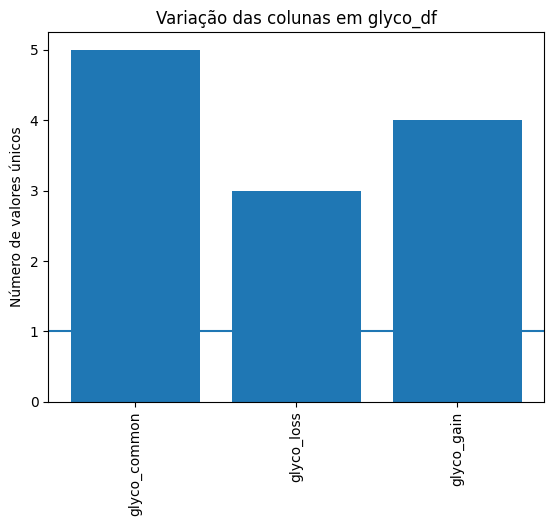


=== protein_analysis_df ===
              column  n_unique_values  constant
0   isoeletric_point               63     False
1   molecular_weight              140     False
2        aromaticity               13     False
3  instability_index              127     False
4              gravy              113     False


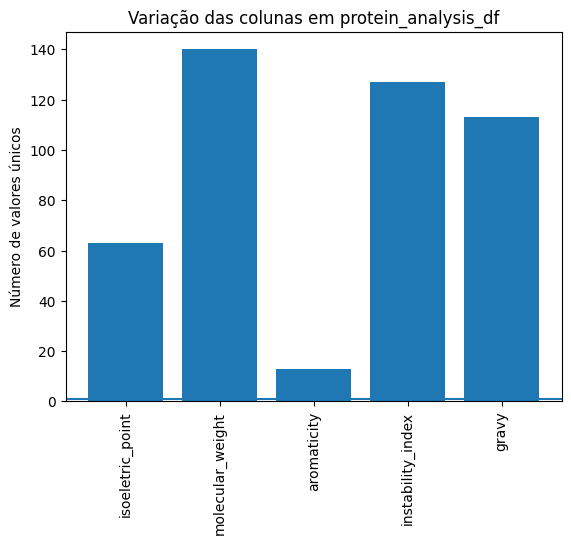

In [28]:

def check_constant_columns(df, name, id_cols=("id", "Accession")):
   
    cols_to_check = [c for c in df.columns if c not in id_cols]
    
    nunique = df[cols_to_check].nunique(dropna=False)
    
    summary = pd.DataFrame({
        "column": nunique.index,
        "n_unique_values": nunique.values,
        "constant": nunique.values == 1
    })
    
    print(f"\n=== {name} ===")
    print(summary)
    
    # gráfico simples
    plt.figure()
    plt.bar(summary["column"], summary["n_unique_values"])
    plt.axhline(1)
    plt.ylabel("Número de valores únicos")
    plt.title(f"Variação das colunas em {name}")
    plt.xticks(rotation=90)
    plt.show()
    
    return summary


# ---- correr verificações ----
summary_glyco = check_constant_columns(glyco_df, "glyco_df")
summary_protein = check_constant_columns(protein_analysis_df, "protein_analysis_df")



Tanto na adição das features de N-glyco motif analysis, como as de protein analysis, estas variam e portanto devem trazer bastante informação que esperemos não ser 'barulho'

## Machine learning v2

### Random Forest:

In [29]:
dataset_ml

,id,dist_HK2014,dist_KAN2017,dist_TAS2020,dist_DAR2021,dist_MAS2022,dist_consensus,glyco_common,glyco_loss,glyco_gain,isoeletric_point,molecular_weight,aromaticity,instability_index,gravy,target_p_epitope
0,MK898525,9,16,20,26,33,7,11,0,2,8.299547,63654.6567,0.093640,33.858657,-0.366254,0.09756
1,MK502696,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
2,MK400756,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
3,MK400758,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
4,MK381485,7,15,18,24,31,5,11,0,2,8.299547,63652.6177,0.093640,34.720318,-0.362898,0.09756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,LC155875,24,25,33,38,43,23,12,0,1,8.504428,63596.5198,0.090106,34.964488,-0.387633,0.14286
236,LC155888,21,20,31,36,41,20,11,1,1,8.175510,63548.4320,0.090106,34.562014,-0.371908,0.09756
237,LC155876,22,21,29,34,39,19,11,1,1,8.499206,63407.3903,0.090106,32.886219,-0.366608,0.19048
238,LC155892,23,24,30,35,39,20,12,0,1,8.580242,63392.3789,0.090106,31.670848,-0.370318,0.19048


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
X = dataset_ml.drop(columns=["id", "target_p_epitope"])
y = dataset_ml["target_p_epitope"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [8, 12, 15, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

Melhores parâmetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}


In [ ]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=2, max_features='sqrt', random_state=42)


rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RF RMSE: {rmse_rf:.4f}")
print(f"RF R²: {r2_rf:.4f}")

RF RMSE: 0.0193
RF R²: 0.8273


Sucesso!!!


Está a conseguir explicar 82.7% da variação do escape antigénico. Qualquer valor acima de 0.70 é geralmente considerado um modelo muito forte.
O erro médio é de apenas 1.9%. Se considerarmos que o $pEpitope$ varia entre 0 e 0.19, errar por apenas 0.019 significa que o modelo está a acertar na maioria das previsões.

In [ ]:
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importances)

              Feature  Importance
0         dist_HK2014    0.140673
6        glyco_common    0.136116
8          glyco_gain    0.121853
5      dist_consensus    0.093053
12  instability_index    0.076764
1        dist_KAN2017    0.073738
4        dist_MAS2022    0.065989
3        dist_DAR2021    0.058109
2        dist_TAS2020    0.055620
10   molecular_weight    0.048105
11        aromaticity    0.042201
9    isoeletric_point    0.037546
13              gravy    0.032679
7          glyco_loss    0.017554


**dist_HK2014 (0.140)**: Continua a ser a "âncora histórica". O modelo usa a distância a 2014 para situar o vírus na árvore evolutiva.


**glyco_common (0.136)**: A grande descoberta! O facto de os motifs de glicosilação comuns serem quase tão importantes como a distância genética mostra que a conservação do "escudo de açúcar" é fundamental para a estabilidade antigénica.


**glyco_gain (0,121)**: O ganho de novos sítios de glicosilação é um preditor fortíssimo de escape. O vírus escapa antigenicamente ganhando açúcares.

**dist_consensus (0.093)**: Logicamente, estar longe da "média" da população atual é um sinal claro de deriva antigénica.

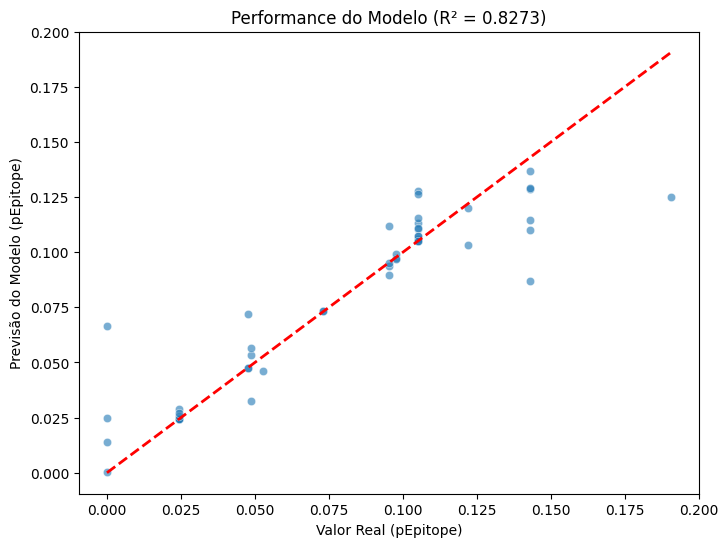

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valor Real (pEpitope)')
plt.ylabel('Previsão do Modelo (pEpitope)')
plt.title(f'Performance do Modelo (R² = {r2_rf:.4f})')
plt.show()

=== Relatório de Validação Cruzada (10-Fold) ===
R² Médio: 0.8613 (+/- 0.0670)
RMSE Médio: 0.0148 (+/- 0.0042)


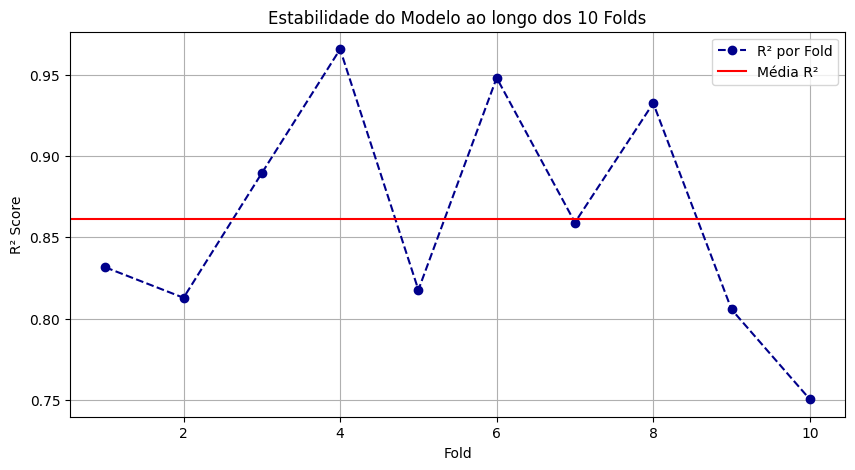

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# 1. Definir o modelo com os melhores parâmetros que o GridSearch encontrou
rf_final = RandomForestRegressor(
    n_estimators=1000, 
    min_samples_split=2, 
    max_features='sqrt', 
    random_state=42
)

# 2. Configurar o K-Fold (10 folds é ideal para N=240)
# shuffle=True é importante para garantir que a ordem cronológica não vicie os grupos
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 3. Executar a Validação Cruzada para R²
cv_r2_scores = cross_val_score(rf_final, X, y, cv=kf, scoring='r2')

# 4. Executar a Validação Cruzada para RMSE (neg_root_mean_squared_error retorna valores negativos)
cv_rmse_scores = -cross_val_score(rf_final, X, y, cv=kf, scoring='neg_root_mean_squared_error')

print("=== Relatório de Validação Cruzada (10-Fold) ===")
print(f"R² Médio: {np.mean(cv_r2_scores):.4f} (+/- {np.std(cv_r2_scores):.4f})")
print(f"RMSE Médio: {np.mean(cv_rmse_scores):.4f} (+/- {np.std(cv_rmse_scores):.4f})")

# Visualizar a estabilidade dos Folds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), cv_r2_scores, marker='o', linestyle='--', color='darkblue', label='R² por Fold')
plt.axhline(y=np.mean(cv_r2_scores), color='r', linestyle='-', label='Média R²')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('Estabilidade do Modelo ao longo dos 10 Folds')
plt.legend()
plt.grid(True)
plt.show()

Análise do Relatório de Validação

$R^2$ Médio (0.8613): O modelo subiu de 0.82 (no split único) para 0.86 na média da validação. Isso prova que o modelo não só aprendeu os dados, como tem uma capacidade de generalização superior à esperada. Explicas 86% da variabilidade do escape antigénico.

RMSE Médio (0.0148): O erro médio baixou para menos de 1.5%. Numa escala onde o escape máximo é ~0.20, um erro de 0.0148 é quase insignificante. O modelo é cirúrgico na predição.

Estabilidade (+/- 0.0670): O desvio padrão é baixo. Isto significa que o modelo é resiliente; ele não depende de um conjunto específico de dados para funcionar.